In [1]:
import torch
import torchvision
from torchvision import datasets,transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable 
import time
%matplotlib inline
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import torch.nn as nn

In [2]:
df = pd.read_excel('mci_conversion.xlsx')
df

,Unnamed: 0,RID,COLPROT,PTID,EXAMDATE,AGE,PTGENDER,CDRSB,MMSE,Hippocampus,WholeBrain,FDG,convert
0,3,51,1,099_S_0051,12/8/2005,66.5,0,1.0,27,6232.0,1098620.0,1.38960,0
1,4,54,1,099_S_0054,12/16/2005,81.0,1,2.5,27,4845.0,833179.0,0.93668,1
2,5,57,1,018_S_0057,1/6/2006,77.3,0,1.5,27,6767.0,1016500.0,1.06972,1
3,7,80,1,018_S_0080,1/13/2006,85.0,0,1.5,27,6482.0,925480.0,1.15745,0
4,9,101,1,007_S_0101,1/4/2006,73.6,0,0.5,27,6527.0,1081740.0,1.21602,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,537,4723,2,135_S_4723,6/5/2012,69.4,1,1.0,30,7759.0,1054570.0,1.46803,0
463,538,4813,2,053_S_4813,7/20/2012,67.6,0,1.0,29,8050.0,1015620.0,1.34695,0
464,539,4869,2,027_S_4869,9/10/2012,77.2,0,1.5,29,7689.0,1097580.0,1.39071,0
465,540,4896,2,126_S_4896,8/27/2012,68.1,0,1.0,30,7819.0,1230370.0,1.34987,0


In [3]:
transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

In [4]:
pid = 'MCI_MPRAGE_2_016_S_1138a.jpg'

label = df.loc[df['PTID']== pid[13:23]]['AGE'].reset_index()
label['AGE'][0]

# c = df.loc[df['PTID']== pid[13:23]]['convert'].reset_index()
# c = c['convert'][0]
# c

67.4

In [5]:
# ADNI_002_S_0559_MR_MPR____N3__Scaled_2_Br_20081001115336170_S15922_I118679
class MyDataset(Dataset):
    def __init__(self, path, df, transform=transform):
        self.transform = transform
        self.images = os.listdir(path)
        self.labels = df
        self.path = path
 
    def __len__(self):
        return len(self.images)
 
    def __getitem__(self, index):
        img = cv2.imread(os.path.join(self.path,self.images[index]))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img2 = np.zeros_like(img)
        img2[:,:,0] = gray
        img2[:,:,1] = gray
        img2[:,:,2] = gray
        cv2.imwrite('./mci_rgb/'+self.images[index], img2)
        img = Image.open('./mci_rgb/'+self.images[index])
#         img = self.images[index, :, :, :]
#         img = img/1.0
#         img = torch.from_numpy(img).float()
#         label = self.labels[index]
        df_ = self.labels
        pid = self.images[index]
        sex = df_.loc[df_['PTID']== pid[0:10]]['PTGENDER'].reset_index()
        sex = sex['PTGENDER'][0]
        label = df_.loc[df_['PTID']== pid[0:10]]['AGE'].reset_index()
        label = label['AGE'][0]      
        conversion = df_.loc[df_['PTID']== pid[0:10]]['convert'].reset_index()
        convert = conversion['convert'][0]

        sample = {'image': img, 'label': label, 'sex': sex, 'convert': convert}
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        return sample

In [6]:
path = './mci_jpg'
dataset = MyDataset(path=path,df=df)

In [7]:
print(len(dataset))
print(dataset[0]['image'].shape)

200
torch.Size([3, 224, 224])


In [8]:
fedataset,maledataset=[],[]
for data in dataset:
    if data['sex'] == 1:
        fedataset.append(data)
    else:
        maledataset.append(data)

print(len(fedataset))
print(len(maledataset))
print(fedataset[0]['image'].shape)

53
147
torch.Size([3, 224, 224])


In [9]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

False


In [10]:
model = models.vgg19()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [11]:
for parma in model.parameters():
    parma.requires_grad = False

model.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 1))
    
if use_gpu:
    model = model.cuda()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [12]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [13]:
model.load_state_dict(torch.load('./fe_best_model.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [14]:
from sklearn.metrics import mean_squared_error,r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [15]:
converts,retains=[],[]
for data in fedataset:
    output = model(data['image'].unsqueeze(0)).detach().numpy()
    trueage = data['label']
    agegap = output - trueage
    if data['convert']==0:
        retains.extend(agegap)
    else:
        converts.extend(agegap)
 

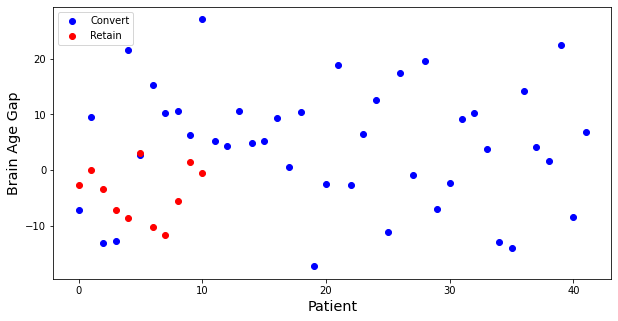

In [16]:
plt.figure(figsize=(10, 5))
 
num_c = range(0,len(converts))
num_r = range(0,len(retains))

plt.scatter(num_c, converts, color='blue', label="Convert")
plt.scatter(num_r, retains, color='red', label="Retain")

plt.ylabel("Brain Age Gap", fontsize='x-large')
plt.xlabel("Patient", fontsize='x-large')
plt.legend()

plt.show()


Brain Age Gap of Conversion
               0
count  42.000000
mean    4.501286
std    10.909608
min   -17.307739
25%    -2.410088
50%     5.216698
75%    10.528124
max    27.080593

Brain Age Gap of Retaining
               0
count  11.000000
mean   -4.096356
std     4.890091
min   -11.575325
25%    -7.853943
50%    -3.435814
75%    -0.211388
max     3.123039


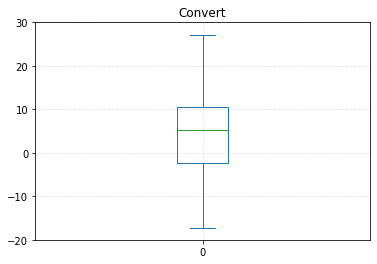

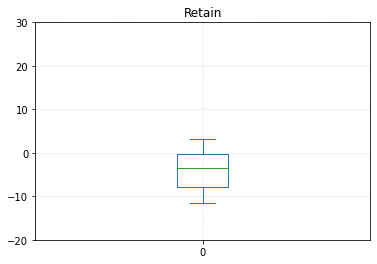

In [18]:
df_converts = pd.DataFrame(converts)

print('Brain Age Gap of Conversion')
print(df_converts.describe())
df_converts.plot.box(title="Convert")
plt.grid(linestyle="--", alpha=0.3)
plt.ylim(-20,30)
print()
df_retains = pd.DataFrame(retains)
print('Brain Age Gap of Retaining')
print(df_retains.describe())
df_retains.plot.box(title="Retain")
plt.grid(linestyle="--", alpha=0.3)
plt.ylim(-20,30)
plt.show()

In [ ]:
# male

In [31]:
model.load_state_dict(torch.load('./m_best_model_3.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [32]:
converts,retains=[],[]
for data in maledataset:
    output = model(data['image'].unsqueeze(0)).detach().numpy()
    trueage = data['label']
    agegap = output - trueage
    if data['convert']==0:
        retains.extend(agegap)
    else:
        converts.extend(agegap)

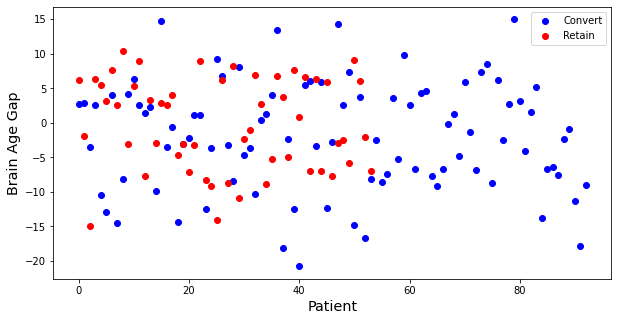

In [33]:
plt.figure(figsize=(10, 5))
 
num_c = range(0,len(converts))
num_r = range(0,len(retains))

plt.scatter(num_c, converts, color='blue', label="Convert")
plt.scatter(num_r, retains, color='red', label="Retain")

plt.ylabel("Brain Age Gap", fontsize='x-large')
plt.xlabel("Patient", fontsize='x-large')
plt.legend()

plt.show()

Brain Age Gap of Conversion
               0
count  93.000000
mean   -1.962874
std     7.910047
min   -20.787971
25%    -7.719017
50%    -2.333054
75%     3.729530
max    14.983139

Brain Age Gap of Retaining
               0
count  54.000000
mean   -0.157629
std     6.696315
min   -14.861404
25%    -5.625874
50%    -0.106659
75%     6.150148
max    10.331421


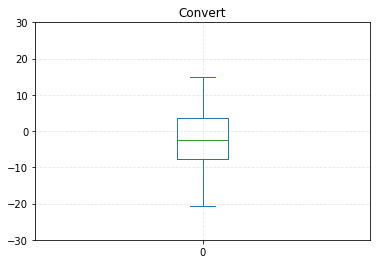

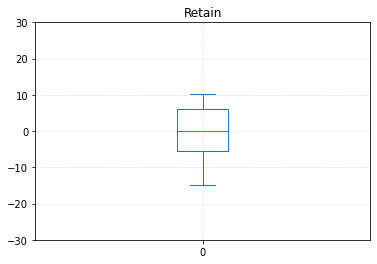

In [35]:
df_converts = pd.DataFrame(converts)

print('Brain Age Gap of Conversion')
print(df_converts.describe())
df_converts.plot.box(title="Convert")
plt.grid(linestyle="--", alpha=0.3)
plt.ylim(-30,30)
print()
df_retains = pd.DataFrame(retains)
print('Brain Age Gap of Retaining')
print(df_retains.describe())
df_retains.plot.box(title="Retain")
plt.grid(linestyle="--", alpha=0.3)
plt.ylim(-30,30)
plt.show()